<a href="https://colab.research.google.com/github/ppspro/PRODIGY_GA_05/blob/main/styletransferprodigy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

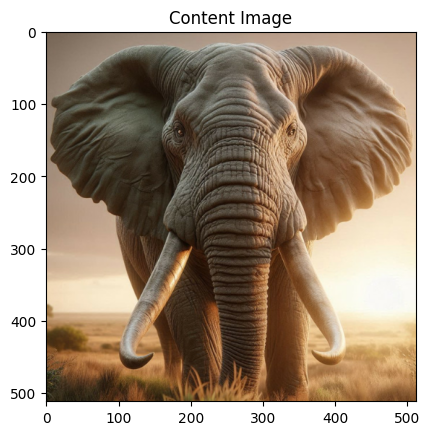

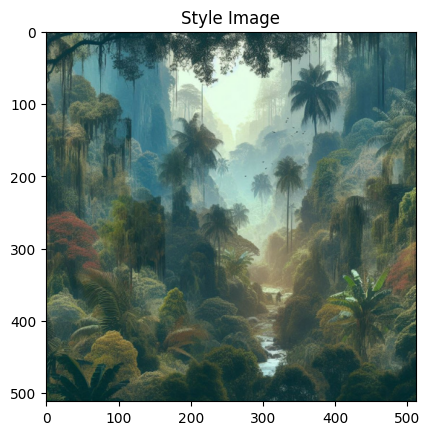

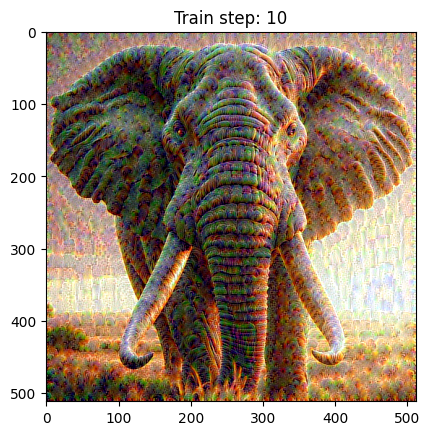

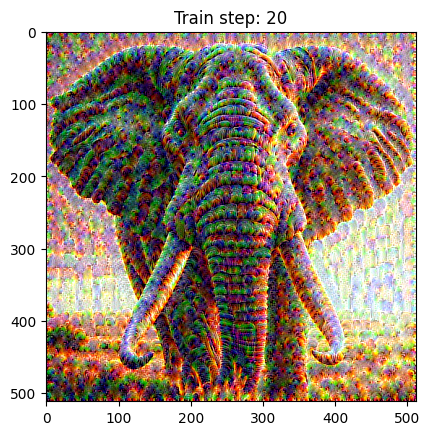

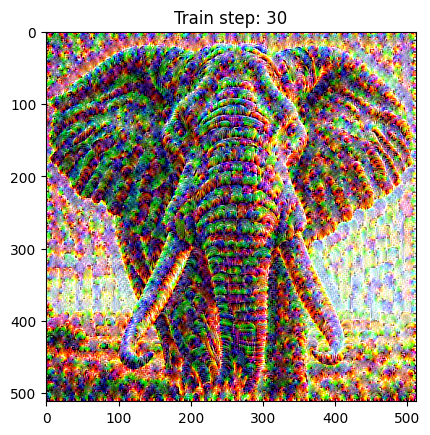

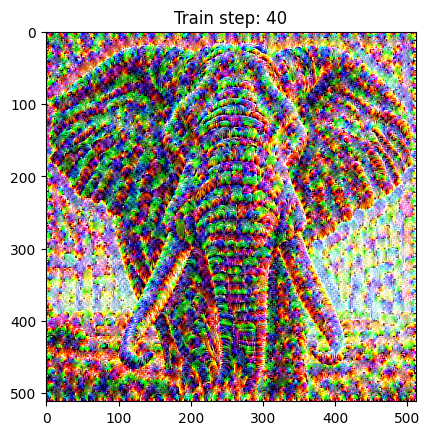

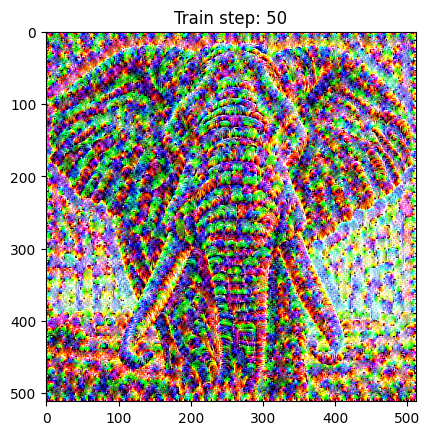

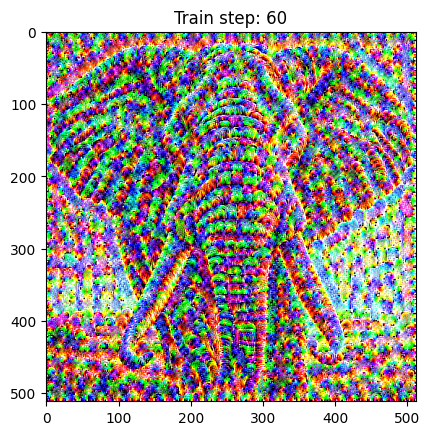

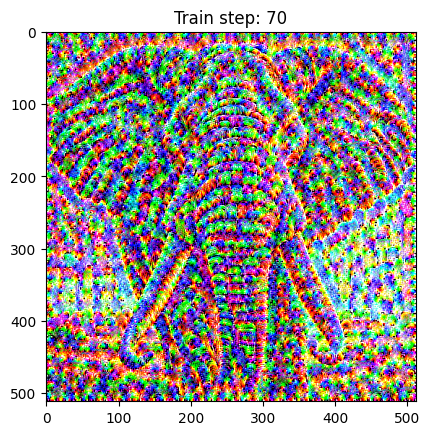

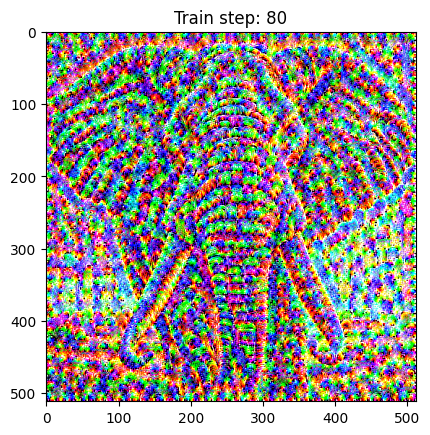

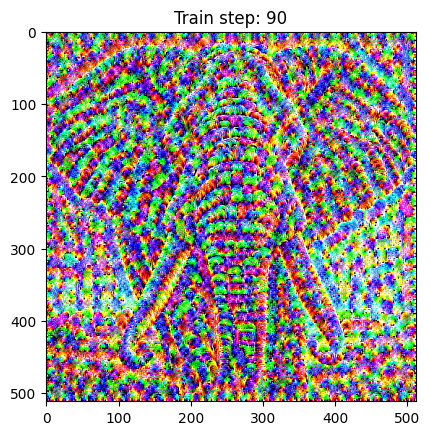

Total time: 15.7


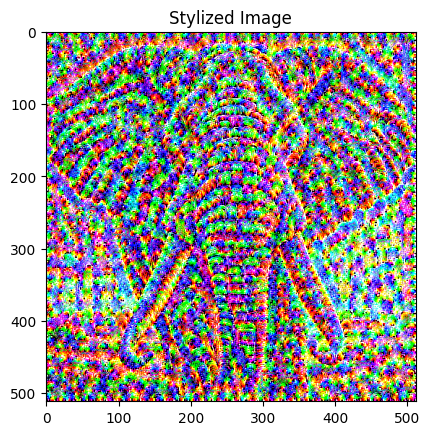

In [ ]:
import tensorflow as tf
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import requests # Import requests to fetch data from URL

# Load and preprocess images
def load_img(path_to_img):
    max_dim = 512
    # Fetch image from the URL
    response = requests.get(path_to_img)
    img = tf.image.decode_image(response.content, channels=3) # Decode the image from the response content
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.show()

content_path = 'https://i.ibb.co/p4HGktj/Designer.jpg'
style_path = 'https://i.ibb.co/fSvpk3Q/Designer-1.jpg'

content_image = load_img(content_path)
style_image = load_img(style_path)

imshow(content_image, 'Content Image')
imshow(style_image, 'Style Image')

# Define model and layers to use
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

style_extractor = vgg_layers(style_layers)
content_extractor = vgg_layers(content_layers)

def gram_matrix(input_tensor):
    # Add a batch dimension if missing
    if len(input_tensor.shape) == 3:
        input_tensor = tf.expand_dims(input_tensor, axis=0)

    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-gram_matrix(style_targets[name]))**2)
                           for name in style_outputs.keys()])
    style_loss *= 1.0 / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= 1.0 / num_content_layers
    loss = style_loss + content_loss
    return loss

# Extract style and content
style_targets = style_extractor(style_image)
content_targets = content_extractor(content_image)

# Train the model
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        content_dict = {content_name:value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}
        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}
        return {'content':content_dict, 'style':style_dict}

extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

total_variation_weight = 30

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image) # Now total_variation_weight is defined
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

import time
start = time.time()

epochs = 9
steps_per_epoch = 10

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
    # Squeeze the image tensor to remove the batch dimension before displaying
    plt.imshow(tf.squeeze(image.read_value()))
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

# Display the final stylized image
imshow(image, 'Stylized Image')
